In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 
from prettytable import PrettyTable 
from gtda.plotting import plot_point_cloud, plot_diagram, plot_heatmap
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, NumberOfPoints, Amplitude, PersistenceImage, HeatKernel




# Basic functions

In [3]:
BASE_PATH = "./"

### Plot 3d graph

In [4]:
def plot3dEntropyValues(data, labels, groups_per_label, noise):
    output_base_path = "./output/plotEntropy/"
    os.makedirs(output_base_path, exist_ok=True)  # Ensure the directory exists
    colors = ['g', 'y', 'b', 'k', 'pink']
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range(len(labels)):
        data_group = data[groups_per_label*i:groups_per_label*(i+1)]
        ax.scatter([p[0] for p in data_group], 
                [p[1] for p in data_group],
                [p[2] for p in data_group], c=colors[i], label=labels[i])
                
        ax.set_xlabel("H0")
        ax.set_ylabel("H1")
        ax.set_zlabel("H2")
    plt.title(f"Entropy values of data with {noise} noise std")
    plt.legend()
    # Save the figure to the specified output path
    output_file_path = os.path.join(output_base_path, f"plot_entropy_{noise}_noise.png")
    plt.savefig(output_file_path, dpi=300)  # Save as a high-resolution PNG
    plt.show()

In [5]:
def plot3dGeneric(data, data_label, title, axis_labels, save_fig=False, color='b', x_limits=None, y_limits=None, z_limits=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # Scatter plot
    ax.scatter(
        [p[0] for p in data], 
        [p[2] for p in data], 
        [p[1] for p in data], 
        c=color, label=data_label
    )
    
    # Set axis labels
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[2])
    ax.set_zlabel(axis_labels[1])
    
    # Set axis limits if provided
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    if z_limits:
        ax.set_zlim(z_limits)
    
    # Set title and legend
    plt.title(title)
    plt.legend()
    
    # Save the figure
    if save_fig:
        output_file_path = os.path.join("BASE_PATH", f"output/{title}.png")
        plt.savefig(output_file_path, dpi=300)
    
    plt.show()

In [6]:
def plot3dGenericClasses(data, data_label, title, axis_labels, save_fig=False, x_limits=None, y_limits=None, z_limits=None, colors=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # Scatter plot
    i = 0
    for label in data_label:
        #Extract the data points
        x_vals = [p[0] for p in data[label]]
        y_vals = [p[2] for p in data[label]]
        z_vals = [p[1] for p in data[label]]
        
        # Plot the first value as an 'X'
        ax.scatter(x_vals[0], z_vals[0], y_vals[0], label="No Noise (First Point)" if i == 0 else None, marker='x', color=colors[i] if colors else None)
        
        # Plot the last value as a triangle
        ax.scatter(x_vals[-1], z_vals[-1], y_vals[-1], label="0.001 Noise (Best KNN Accuracy)" if i == 0 else None, marker='^', color=colors[i] if colors else None)
        
        # Plot intermediate values as circles
        if len(x_vals) > 2:  # Check to avoid errors with very small data sets
            ax.scatter(x_vals[1:-1], z_vals[1:-1], y_vals[1:-1], label=label, marker='o', color=colors[i] if colors else None)
        
        i += 1
    
    # Set axis labels
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[2])
    ax.set_zlabel(axis_labels[1])
    
    # Set axis limits if provided
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    if z_limits:
        ax.set_zlim(z_limits)
    
    # Set title and legend
    plt.title(title)
    plt.legend()
    ax.legend(bbox_to_anchor=(1.15, 0.5), loc='center left')
    
    # Save the figure
    if save_fig:
        output_file_path = os.path.join("BASE_PATH", f"output/{title}.png")
        plt.savefig(output_file_path, dpi=300)
    
    plt.show()

### Load dataset

In [7]:
def loadFigures(OPTION, samples, figures, maximum_samples_per_figure, noise_mean=0.0, noise_std=0.01):
    #OPTION : Lets you choose where to get data from 
    #samples : Number of samples per group 
    #figures : The Different Shapes 
    # maximum_samples_per_figure : Maximum number of presampling before shuffling and partitioning
    # #noise_mean, noise_std : Gaussian noise parameters 
    #This function works by first obtaining all or at most maximum_samples_per_figure for each data set of that figure, then shuffling and partitioning them according to samples
    #Then the function returns a list of data and labels where the ith element of data is a an array of samples, and the ith element of label is the label of the correspoonding figure of 
    # the ith element of data  
    data = []
    labels = []
    for index, figure in enumerate(figures):
        #print(figure)
        data_fig = []
        
        DATASET_DIR = ""
        match(OPTION):
            case "virtual-standard":
                DATASET_DIR = f'../../Datasets/haptic/digital_haptic/21K_random_angles_test/FINGERDIST/1.0/BL/{figure}_VEL_10_NOISE_0.000000.txt'
            case "virtual-face":
                DATASET_DIR = 'haptic_one-side_21k/'+figure+'_VEL_1.txt'
            case "virtual-2.5":
                DATASET_DIR = BASE_PATH + 'new_haptic_system/21K_random_angles_test/FINGERDIST/2.5/BL/'+figure+'_VEL_10_NOISE_0.000000.txt'
            case "real":
                DATASET_DIR = BASE_PATH + 'RealRobot/output/'+figure+'.txt'

        # Read samples
        with open(DATASET_DIR, 'r') as file:
            i = 0
            for line in file:
                # Split each line by spaces and extend the data_list
                sample = np.array(line.split()[0:3], dtype='float32')  # Values
                # Add Gaussian noise to the sample
                noisy_sample = sample + np.random.normal(noise_mean, noise_std, sample.shape)
                data_fig.append(noisy_sample)
                i = i+1
                if (i == maximum_samples_per_figure): 
                    break
        
        #All shuffle
        data_fig = np.array(data_fig)
        #print(f"\tOriginal Data shape: {data_fig.shape}")
        np.random.shuffle(data_fig)
        
        #plot3dGeneric(data_fig, figure, f"Point cloud of figure {figure} - noise std = {noise_std}", ["1st finger", "2nd finger", "3rd finger"], x_limits=(0, 1.2), y_limits=(0, 1.2), z_limits=(0, 0.9))

        minimum = min(int(data_fig.shape[0]/samples), 200)
        #print(f"\t{minimum} groups with {samples} samples each")
        for i in range(minimum):
            group = []
            for j in range(samples):
                group.append(data_fig[i*samples+j])
            if i < 0:
                plot3dGeneric(group, figure, f"Point cloud - {samples} samples of figure {figure} - noise std = {noise_std}", ["1st finger", "2nd finger", "3rd finger"], x_limits=(0, 1.2), y_limits=(0, 1.2), z_limits=(0, 0.9))
            data.append(group)
            labels.append(index)

    # Convert images and labels to numpy arrays
    data = np.array(data, dtype='float32')
    labels = np.array(labels, dtype='float32')

    return data, labels

# TDA functions

### Persistence diagrams using Vietoris Rips

In [8]:
HOMOLOGY_DIMENSIONS = [0, 1, 2]

def getPersistenceDiagrams(data_in):
    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=HOMOLOGY_DIMENSIONS,
        n_jobs=6,
        collapse_edges=True,
    )
    
    try:
        diagrams = persistence.fit_transform(data_in)
    except Exception as e:
        print(e)
    return diagrams

### Persistence Entropy

In [9]:
def getPersistenceEntropy(diagrams_in):
    persistence_entropy = PersistenceEntropy()
    entropy_values = persistence_entropy.fit_transform(diagrams_in)
    return entropy_values

### Persistence Image

In [10]:
def getPersistenceImage(diagrams_in):
    PI = PersistenceImage(n_jobs = -1)
    persistence_images = PI.fit_transform(diagrams_in)
    return persistence_images

### Table of metrics

In [11]:
import pandas as pd

def generateTableOfMetrics(diagrams_in, entropy_values, groups_per_label, figures, noise, show=False):
    '''
    diagrams_in : list of persistence diagrams 
    entropy_values : list of entropy values 
    groups_per_label : number of groups per label 

    For every persistence diagram, each metric computes a vector of norms of the each persistence subdiagram (separated according to homology dimension) induced by the metric.
    This fuction then returns a table of the mean of these norms for each figure
    '''
    output_base_path = "./output/metricsTable/"
    os.makedirs(output_base_path, exist_ok=True)  # Ensure the directory exists
    #print("\tNumber of points in process...")
    n_points = NumberOfPoints().fit_transform(diagrams_in)
    #print("\twasserstein in process...")
    wass_dist = Amplitude(metric='wasserstein').fit_transform(diagrams_in)
    #print("\tbottleneck in process...")
    bot_dist = Amplitude(metric='bottleneck').fit_transform(diagrams_in)
    land_dist = Amplitude(metric='landscape').fit_transform(diagrams_in)
    #print("\tlandscape in process...")
    #print("\tpersistence_image in process...")
    #img_dist = Amplitude(metric='persistence_image').fit_transform(diagrams_in)
    #print("\tbett iin process...")
    betti = Amplitude(metric='betti').fit_transform(diagrams_in)

    # Prepare table data
    table_data = []
    # so each type of object compute the 
    for i in range(len(figures)):
        row = [
            figures[i],
            [float("{:.2f}".format(x)) for x in np.mean(entropy_values[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(n_points[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(wass_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(bot_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(land_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(betti[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
        ]
        table_data.append(row)
    # for i in range(len(table_data)):
    #     print(table_data[i])
    # Save table data as .npy

    table_data_num = [row[1:] for row in table_data]
    output_file_path = os.path.join(output_base_path, f"metrics_table_{noise}_noise.npy")
    np.save(output_file_path, table_data_num)   
    table = PrettyTable(['Figure', 'Entropy centroid', 'Number of points', 'Wasserstein distance', 'Bottleneck distance', 'Landscape distance', 'Betti numbers'])
    for row in table_data:
        table.add_row(row)
    if show:
        print(table)    
    return table_data

In [12]:
import pandas as pd

def generateTableOfMetrics(diagrams_in, entropy_values, groups_per_label, figures, noise, show=False):
    '''
    diagrams_in : list of persistence diagrams 
    entropy_values : list of entropy values 
    groups_per_label : number of groups per label 

    For every persistence diagram, each metric computes a vector of norms of the each persistence subdiagram (separated according to homology dimension) induced by the metric.
    This fuction then returns a table of the mean of these norms for each figure
    '''
    output_base_path = "./output/metricsTable/"
    os.makedirs(output_base_path, exist_ok=True)  # Ensure the directory exists
    #print("\tNumber of points in process...")
    n_points = NumberOfPoints().fit_transform(diagrams_in)
    #print("\twasserstein in process...")
    wass_dist = Amplitude(metric='wasserstein').fit_transform(diagrams_in)
    #print("\tbottleneck in process...")
    bot_dist = Amplitude(metric='bottleneck').fit_transform(diagrams_in)
    land_dist = Amplitude(metric='landscape').fit_transform(diagrams_in)
    #print("\tlandscape in process...")
    #print("\tpersistence_image in process...")
    #img_dist = Amplitude(metric='persistence_image').fit_transform(diagrams_in)
    #print("\tbett iin process...")
    betti = Amplitude(metric='betti').fit_transform(diagrams_in)

    # Prepare table data
    table_data = []
    # so each type of object compute the 
    for i in range(len(figures)):
        row = [
            figures[i],
            [float("{:.2f}".format(x)) for x in np.mean(entropy_values[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(n_points[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(wass_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(bot_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(land_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(betti[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
        ]
        table_data.append(row)
    # for i in range(len(table_data)):
    #     print(table_data[i])
    # Save table data as .npy

    table_data_num = [row[1:] for row in table_data]
    output_file_path = os.path.join(output_base_path, f"metrics_table_{noise}_noise.npy")
    np.save(output_file_path, table_data_num)   
    table = PrettyTable(['Figure', 'Entropy centroid', 'Number of points', 'Wasserstein distance', 'Bottleneck distance', 'Landscape distance', 'Betti numbers'])
    for row in table_data:
        table.add_row(row)
    if show:
        print(table)    
    return table_data

# KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [14]:
def KNN_classifications(entropy_values, expected_output, groups_per_figure, test_size=0.2, random_state=None):
    """
    entropy_values : array of entropy values 
    expected_output : array of the corresponding figure labeles 
    groups_per_figure : not used 
    test_size : proportion of the test set
    random_state : seed for reproduction
    """
    # Ensure inputs are numpy arrays for consistency
    entropy_values = np.array(entropy_values)
    expected_output = np.array(expected_output)
    
    # Validate inputs
    if len(entropy_values) != len(expected_output):
        raise ValueError("Length of entropy_values and expected_output must be the same.")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        entropy_values,  # Reshape to 2D array
        expected_output,
        test_size=test_size,
        random_state=random_state
    )
    
    # Initialize the KNN model
    knn = KNeighborsClassifier(n_neighbors=10)
    
    # Fit the model using the training data
    knn.fit(X_train, y_train)
    
    # Predict on the training set
    train_predictions = knn.predict(X_train)
    # Predict on the test set
    test_predictions = knn.predict(X_test)
    
    # Calculate accuracy
    train_accuracy = knn.score(X_train, y_train)
    test_accuracy = knn.score(X_test, y_test)
    
    return {
        "train_predictions": train_predictions,
        "test_predictions": test_predictions,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "knn_model": knn
    }

# Main

In [15]:
# virtual-standard  virtual-face  virtual-2.5  real
OPTION = "virtual-face"
FIGURES = ['lat00', 'lat05', 'lat10', 'lat15', 'lat20']
MAXIMUM_SAMPLES_PER_FIGURE = 21000

## Study of noise and number of groups

In [16]:
num_of_samples_per_group = [10, 50, 100, 200, 400]

Through KNN classification for verification

So we want to see if these other metrics are able to potentially be useful in classifying the convexities. \
So want to obtain these metric (norms) for each homology dimension. \
For each noise level \
For each and sample_group_size \
So pretty much copy the code for the effectiveness of kNN, but instead of running the kNN, just make a plot of each norm 


In [17]:
print(num_of_samples_per_group)

[10, 50, 100, 200, 400]


In [42]:
import pandas as pd

noise_values = {}
test_accuracy_valies = {}
NUM_EXPERIMENTS = 10
translate = {0 : "entropy", 1 : "n_points", 2 : "wass_dist", 3 : "bot_dist", 4 : "land_dist", 5 : "betti"}
# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=['num_samp', 'noise', 'fig', 'norm', 'data'])
for i in range(NUM_EXPERIMENTS):
    for samples_per_group in num_of_samples_per_group: 
        if i == 0:
            noise_values[samples_per_group] = []
        noise = 0
        noise_increment = 0.0001 
        MAX_NOISE = 0.05
        j = 0 
        while noise <= MAX_NOISE:
            data, labels = loadFigures(OPTION, samples_per_group, FIGURES, MAXIMUM_SAMPLES_PER_FIGURE, noise_std=noise)
            groups_per_figure = int(data.shape[0]/len(FIGURES))
            fig_1_dat = data[:groups_per_figure]
            fig_2_dat = data[groups_per_figure : 2 * groups_per_figure]
            fig_3_dat = data[2 * groups_per_figure : 3 * groups_per_figure]
            fig_4_dat = data[3 * groups_per_figure : 4 * groups_per_figure]
            fig_5_dat = data[4 * groups_per_figure : 5 * groups_per_figure]

            for k, data in enumerate([fig_1_dat, fig_2_dat, fig_3_dat, fig_4_dat, fig_5_dat]):
                diagrams = getPersistenceDiagrams(data)
                entropy_values = getPersistenceEntropy(diagrams)
                n_points = NumberOfPoints().fit_transform(diagrams)
                wass_dist = Amplitude(metric='wasserstein').fit_transform(diagrams)
                bot_dist = Amplitude(metric='bottleneck').fit_transform(diagrams)
                land_dist = Amplitude(metric='landscape').fit_transform(diagrams)
                betti = Amplitude(metric='betti').fit_transform(diagrams) 
                YY = [entropy_values, n_points, wass_dist, bot_dist, land_dist, betti]
                for ind, x in enumerate(YY):

                    
                    #df = pd.concat([df, pd.DataFrame({'num_samp': samples_per_group, 'noise': noise, 'fig': k+1, 'norm': translate[ind], 'data': x})], ignore_index=True)
                    df.loc[len(df)] = [samples_per_group, noise, k+1, translate[ind], x]
            j += 1
            noise += noise_increment
            if noise >= noise_increment*10:
                noise_increment*=5

                    
            
            

In [43]:
import plotly.graph_objects as go
def plot_norms(norm, noise, num_samp):
    eps = 0.00003
    temp_df = df[(df['norm'] == norm) & (abs(df['noise'] - noise)<= eps) & (df['num_samp'] == num_samp)]
    data_1 = temp_df[temp_df['fig'] == 1].data.iloc[0]
    data_2 = temp_df[temp_df['fig'] == 2].data.iloc[0]
    data_3 = temp_df[temp_df['fig'] == 3].data.iloc[0]
    data_4 = temp_df[temp_df['fig'] == 4].data.iloc[0]
    data_5 = temp_df[temp_df['fig'] == 5].data.iloc[0]

    fig = go.Figure()

    for data, color, name in zip([data_1, data_2, data_3, data_4, data_5], 
                                 ['red', 'blue', 'green', 'purple', 'orange'], 
                                 FIGURES):
        x_coords = [point[0] for point in data]
        y_coords = [point[1] for point in data]
        z_coords = [point[2] for point in data]
        
        fig.add_trace(go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode='markers',
            marker=dict(
                size=5,
                color=color,
                opacity=0.8
            ),
            name=name
        ))
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title=f'3D Scatter Plot of {norm} for {num_samp} samples per group and {noise} noise'
    )

    fig.show()



In [44]:
df.noise.unique()

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
       0.02  , 0.0225, 0.025 , 0.0275, 0.04  ])

In [61]:
plot_norms('betti', 0.02, 100)

In [62]:
plot_norms('wass_dist', 0.02, 50)

In [58]:
plot_norms('land_dist', 0.02, 50)

In [59]:
plot_norms('bot_dist', 0.02, 100)

In [41]:
plot_norms('entropy', 0.005, 50)

In [ ]:
data, label = loadFigures(OPTION, 50, FIGURES, MAXIMUM_SAMPLES_PER_FIGURE, noise_std=0.001)
diagrams = getPersistenceDiagrams(data)
entropy_values = getPersistenceEntropy(diagrams)
groups_per_figure = int(entropy_values.shape[0] / len(FIGURES))
generateTableOfMetrics(diagrams, entropy_values, groups_per_figure, FIGURES, noise=0.001)

In [ ]:
'''
For every number of experiment, for every number of samples per group, for every noise value, 
-load the data and labels. Every list of data consists of samples_per_group samples of haptic data with corresponding noise value for a specific figure.
-get the persistence diagram of each data set
-calculate the entropy value of each data set. (for each data set an array of entropy values of each homology dimension is obtained)
-obtain "groups_per_figure" : the number of entropy values per figure 
-run through the kNN algorithm to classify the data
'''
noise_values = {}
test_accuracy_values = {}
train_accuracy_values = {}
NUM_EXPERIMENTS = 10
for i in range(NUM_EXPERIMENTS):
    print(f"Experiment {i+1}")
    for samples_per_group in num_of_samples_per_group:
        print(f"\t{samples_per_group} samples per group")
        if i == 0:
            noise_values[samples_per_group] = []
            test_accuracy_values[samples_per_group] = []
            train_accuracy_values[samples_per_group] = []
        noise = 0
        noise_increment = 0.0001
        MAX_NOISE = 0.03
        j = 0
        while noise <= MAX_NOISE:
            print(f"\t\tNoise used: {noise}")
            # Get data
            data, labels = loadFigures(OPTION, samples_per_group, FIGURES, MAXIMUM_SAMPLES_PER_FIGURE, noise_std=noise)
            #print(f"\tData shape: {data.shape}")
            #plot_point_cloud(data[8])
            # Get diagrams
            diagrams = getPersistenceDiagrams(data)
            #print(f"\tDiagrams shape: {diagrams.shape}")
            #plot_diagram(diagrams[8])
            # Get entropy values
            entropy_values = getPersistenceEntropy(diagrams)
            #print(f"\tEntropy values shape: {entropy_values.shape}")
            #persistence_images = getPersistenceImage(diagrams)
            #print(f"\tPersistence images shape: {persistence_images.shape}")
            groups_per_figure = int(entropy_values.shape[0] / len(FIGURES))
            # Get table of metrics
            #generateTableOfMetrics(diagrams, entropy_values, groups_per_figure, FIGURES, noise)
            # Plot entropy values
            #plot3dEntropyValues(entropy_values, FIGURES, groups_per_figure, noise)
            # Try classifying with KNN
            result = KNN_classifications(entropy_values, labels, groups_per_figure, test_size=0.2, random_state=None)
            print("\t\tTest accuracy of KNN: " + str(result["test_accuracy"]*100) + "%")
            if i == 0:
                test_accuracy_values[samples_per_group].append(round(result["test_accuracy"]*100/NUM_EXPERIMENTS,2))
                train_accuracy_values[samples_per_group].append(round(result["train_accuracy"]*100/NUM_EXPERIMENTS,2))
                noise_values[samples_per_group].append(noise)
            else:
                test_accuracy_values[samples_per_group][j] += round(result["test_accuracy"]*100/NUM_EXPERIMENTS,2)
                train_accuracy_values[samples_per_group][j] += round(result["train_accuracy"]*100/NUM_EXPERIMENTS,2)
            # Increment noise
            j+=1
            noise += noise_increment
            if noise >= noise_increment*10:
                noise_increment*=10

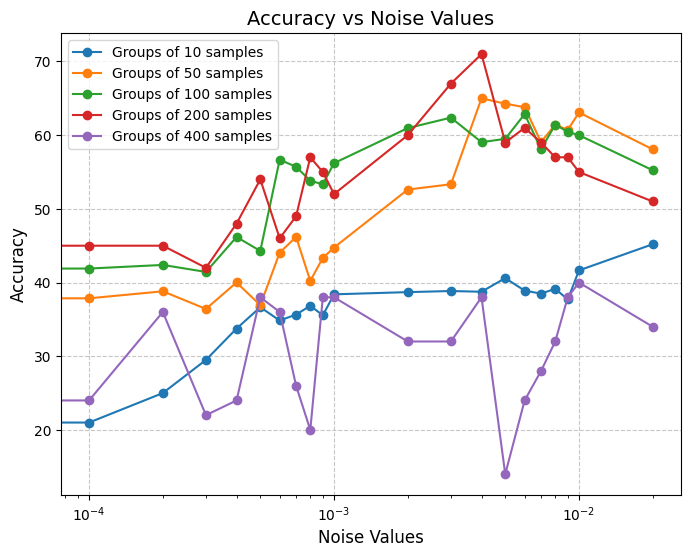

In [33]:
# Plot the graph
plt.figure(figsize=(8, 6))
for samples_per_group in num_of_samples_per_group:
    plt.plot(noise_values[samples_per_group], test_accuracy_values[samples_per_group], marker='o', linestyle='-', label=f"Groups of {samples_per_group} samples")

# Set X-axis to logarithmic scale
plt.xscale('log')

# Add labels and title
plt.xlabel("Noise Values", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy vs Noise Values", fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()
plt.savefig("Euclidean_KNN_Accuracy_vs_Noise.png")

# Show the plot
plt.show()


## Study of centroids

In [65]:
import warnings

# Suppress VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [66]:
# Best case of study in previous section
NUM_SAMPLES_PER_GROUP = 400

noise_values = []
centroid_values = {}
for figure in FIGURES:
    centroid_values[figure] = []
NUM_EXPERIMENTS = 10
for i in range(NUM_EXPERIMENTS):
    print(f"Experiment {i+1}")
    noise = 0
    noise_increment = 0.0001
    MAX_NOISE = 0.0011
    j = 0
    while noise <= MAX_NOISE:
        print(f"\t\tNoise used: {noise}")
        # Get data
        data, labels = loadFigures(OPTION, NUM_SAMPLES_PER_GROUP, FIGURES, MAXIMUM_SAMPLES_PER_FIGURE, noise_std=noise)
        # Get diagrams
        diagrams = getPersistenceDiagrams(data)
        # Get entropy values
        entropy_values = getPersistenceEntropy(diagrams)
        groups_per_figure = int(entropy_values.shape[0] / len(FIGURES))
        # Get table of metrics
        table = generateTableOfMetrics(diagrams, entropy_values, groups_per_figure, FIGURES, noise)
        for k in range(len(FIGURES)):
            if i == 0:
                centroid_values[FIGURES[k]].append(np.array(table[k][1])/NUM_EXPERIMENTS)
            else:
                centroid_values[FIGURES[k]][j] += np.array(table[k][1])/NUM_EXPERIMENTS
        # Increment noise
        j+=1
        if i == 0:
            noise_values.append(noise)
        noise += noise_increment
        if noise >= noise_increment*10:
            noise_increment*=10

Experiment 1
		Noise used: 0
		Noise used: 0.0001
		Noise used: 0.0002
		Noise used: 0.00030000000000000003
		Noise used: 0.0004
		Noise used: 0.0005
		Noise used: 0.0006000000000000001
		Noise used: 0.0007000000000000001
		Noise used: 0.0008000000000000001
		Noise used: 0.0009000000000000002
		Noise used: 0.0010000000000000002
Experiment 2
		Noise used: 0
		Noise used: 0.0001
		Noise used: 0.0002
		Noise used: 0.00030000000000000003
		Noise used: 0.0004
		Noise used: 0.0005
		Noise used: 0.0006000000000000001
		Noise used: 0.0007000000000000001
		Noise used: 0.0008000000000000001
		Noise used: 0.0009000000000000002
		Noise used: 0.0010000000000000002
Experiment 3
		Noise used: 0
		Noise used: 0.0001
		Noise used: 0.0002
		Noise used: 0.00030000000000000003
		Noise used: 0.0004
		Noise used: 0.0005
		Noise used: 0.0006000000000000001
		Noise used: 0.0007000000000000001
		Noise used: 0.0008000000000000001
		Noise used: 0.0009000000000000002
		Noise used: 0.0010000000000000002
Experiment

In [67]:
print(centroid_values)

{'lat00': [array([ 7.762, -0.982, -1.   ]), array([ 7.821, -0.79 , -0.998]), array([ 7.866, -0.385, -0.998]), array([ 7.914,  0.069, -0.998]), array([ 7.947,  0.464, -0.994]), array([ 7.988,  0.93 , -0.991]), array([ 8.022,  1.291, -0.992]), array([ 8.052,  1.572, -0.971]), array([ 8.083,  1.868, -0.975]), array([ 8.111,  2.068, -0.954]), array([ 8.132,  2.354, -0.936])], 'lat05': [array([ 7.563, -0.987, -1.   ]), array([ 7.677, -0.134, -0.998]), array([ 7.782,  1.163, -0.992]), array([ 7.866,  2.054, -0.951]), array([ 7.939,  2.645, -0.928]), array([ 8.001,  3.072, -0.899]), array([ 8.051,  3.425, -0.816]), array([ 8.093,  3.677, -0.77 ]), array([ 8.135,  3.853, -0.698]), array([ 8.169,  4.064, -0.581]), array([ 8.195,  4.21 , -0.537])], 'lat10': [array([ 7.643, -0.845, -1.   ]), array([8.478, 6.055, 2.422]), array([8.486, 6.386, 3.201]), array([8.49 , 6.526, 3.527]), array([8.489, 6.617, 3.734]), array([8.489, 6.678, 3.85 ]), array([8.489, 6.718, 3.968]), array([8.489, 6.75 , 4.048])

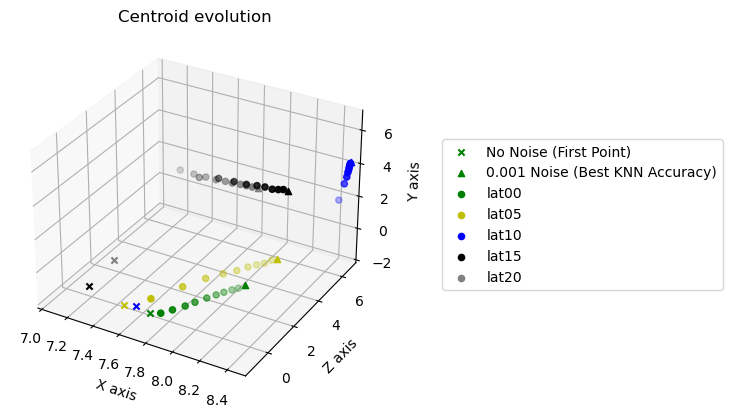

In [91]:
plot3dGenericClasses(centroid_values, FIGURES, f"Centroid evolution", ["X axis", "Y axis", "Z axis"], x_limits= (7,8.5), y_limits=(-1.5,7), z_limits=(-2,7), colors=['g', 'y', 'b', 'k', 'grey'])

## Study of persistence images

In [119]:
# Best case of study in previous section
NUM_SAMPLES_PER_GROUP = 400
NOISE = 0.001

# Get data from datasets
data, labels = loadFigures(OPTION, NUM_SAMPLES_PER_GROUP, FIGURES, MAXIMUM_SAMPLES_PER_FIGURE, noise_std=NOISE)
print(f"Data shape: {data.shape}")
#plot_point_cloud(data[8])

# Get diagrams
diagrams = getPersistenceDiagrams(data)
print(f"Diagrams shape: {diagrams.shape}")
#plot_diagram(diagrams[8])

# Get persistence images
persistence_images = getPersistenceImage(diagrams)
print(f"Persistence images shape: {persistence_images.shape}")

Data shape: (224, 400, 3)
Diagrams shape: (224, 626, 3)
Persistence images shape: (224, 3, 100, 100)


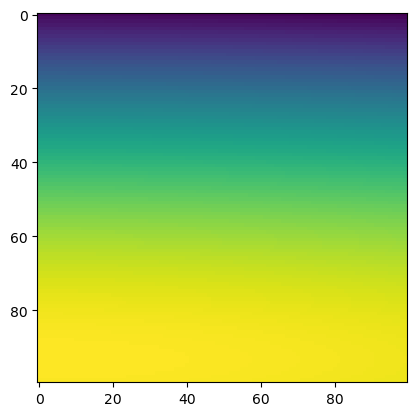

In [120]:
plt.figure()
plt.imshow(persistence_images[10][0])
#plt.imshow(persistence_images[0][0])

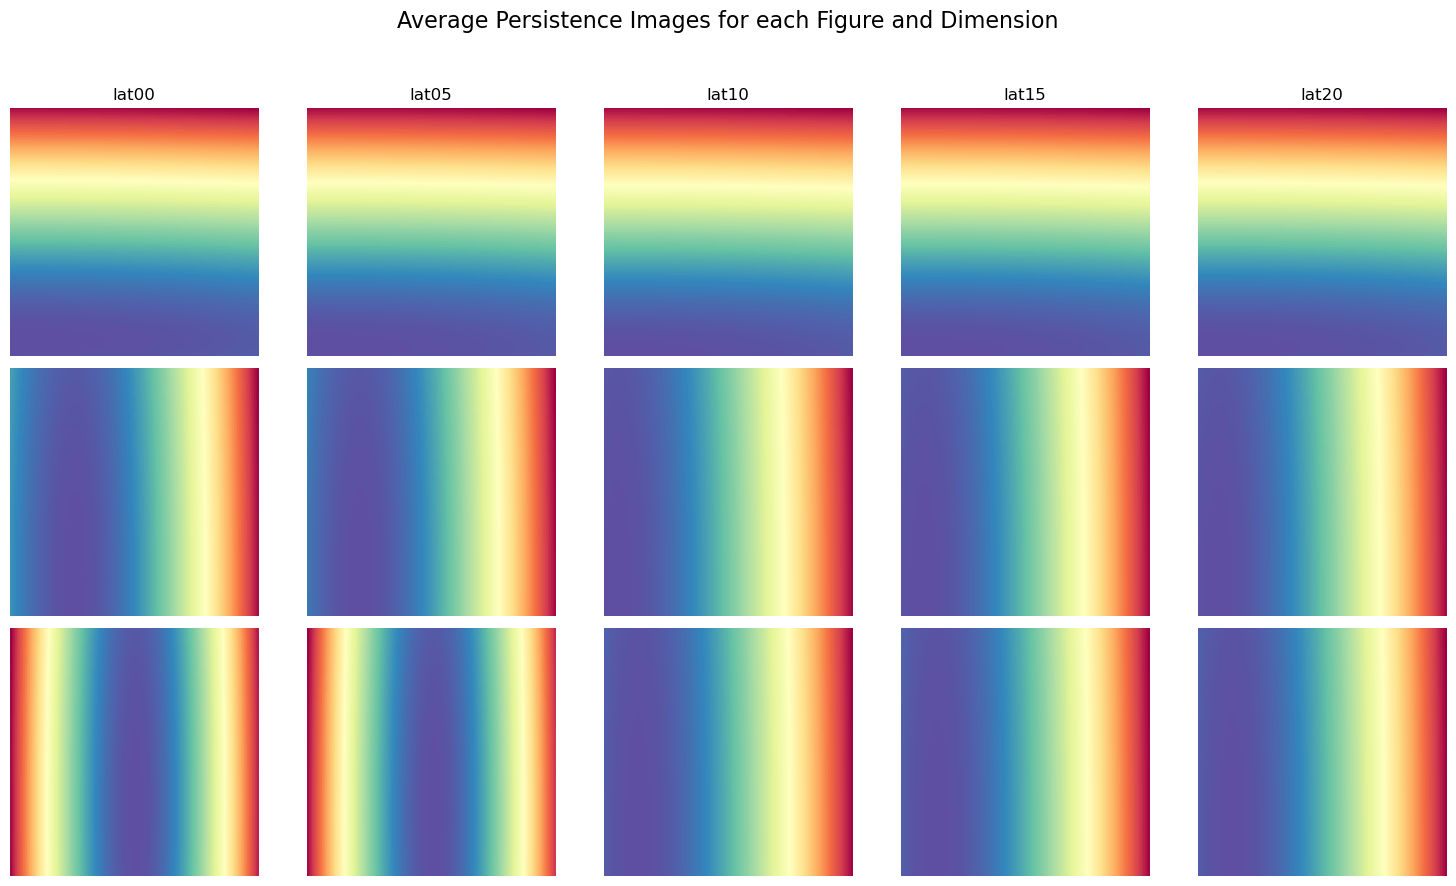

In [121]:
fig, axes = plt.subplots(nrows=3, ncols=len(FIGURES), figsize=(15, 9))  # 3 rows for dimensions, 5 columns for figures
fig.suptitle("Average Persistence Images for each Figure and Dimension", fontsize=16)
#fig.title(f"Groups of {NUM_SAMPLES_PER_GROUP} samples - With {NOISE} noise", fontsize=12)
# Compute and plot the average persistence image for each figure and dimension
for figure in range(len(FIGURES)): 
    for dim in range(3):  
        ax = axes[dim, figure] 
        
        # Select persistence images for this figure
        indices = np.where(labels == figure)[0]    
        figure_images = persistence_images[indices]
        
        # Compute the average persistence image for this dimension
        avg_images = np.mean(figure_images, axis=0) 
        
        # Plot the average persistence image for this dimension
        ax.imshow(avg_images[dim], cmap='Spectral')
        if dim == 0:  # Add title for the top row (figures)
            ax.set_title(f"{FIGURES[figure]}")
        if figure == 0:  # Add labels for the leftmost column (dimensions)
            ax.set_ylabel(f"Dim {dim}", fontsize=12)
        
        ax.axis('off') 

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


In [122]:
unique_figures = range(0,5)

from scipy.stats import entropy

# Normalize persistence images
def normalize_image(image):
    image = image - np.min(image)  # Shift to non-negative values
    image = image / np.sum(image)  # Normalize to sum to 1
    return image

# Compute pairwise KL Divergence
for i, figure1 in enumerate(unique_figures):
    indices1 = np.where(labels == figure1)[0]
    avg_images1 = np.mean(persistence_images[indices1], axis=0)  # Average for figure1

    for j, figure2 in enumerate(unique_figures):
        if i >= j:
            continue

        indices2 = np.where(labels == figure2)[0]
        avg_images2 = np.mean(persistence_images[indices2], axis=0)  # Average for figure2

        # Compute KL Divergence for each dimension
        print(f"KL Divergence between Figure {FIGURES[figure1]} and Figure {FIGURES[figure2]}")
        for dim in range(avg_images1.shape[0]):
            img1 = normalize_image(avg_images1[dim].flatten())
            img2 = normalize_image(avg_images2[dim].flatten())
            kl_div = entropy(img1, img2)
            print(f"\tDimension {dim}: {kl_div:.4f}")

KL Divergence between Figure lat00 and Figure lat05
	Dimension 0: 0.0000
	Dimension 1: 0.0004
	Dimension 2: 0.0005
KL Divergence between Figure lat00 and Figure lat10
	Dimension 0: 0.0002
	Dimension 1: 0.0047
	Dimension 2: inf
KL Divergence between Figure lat00 and Figure lat15
	Dimension 0: 0.0001
	Dimension 1: 0.0036
	Dimension 2: inf
KL Divergence between Figure lat00 and Figure lat20
	Dimension 0: 0.0000
	Dimension 1: 0.0039
	Dimension 2: inf
KL Divergence between Figure lat05 and Figure lat10
	Dimension 0: 0.0001
	Dimension 1: 0.0023
	Dimension 2: inf
KL Divergence between Figure lat05 and Figure lat15
	Dimension 0: 0.0000
	Dimension 1: 0.0015
	Dimension 2: inf
KL Divergence between Figure lat05 and Figure lat20
	Dimension 0: 0.0000
	Dimension 1: 0.0017
	Dimension 2: inf
KL Divergence between Figure lat10 and Figure lat15
	Dimension 0: 0.0000
	Dimension 1: 0.0001
	Dimension 2: 0.0000
KL Divergence between Figure lat10 and Figure lat20
	Dimension 0: 0.0001
	Dimension 1: 0.0000
	Dim